# Movie Analysis

## Introduction
Microsoft has decided to create a new movie studio, and has tasked us  with exploring what types of films are currently doing the best at the box office. We will analyze the market based on a few different metrics and present microsoft with our findings as well as offer insights on the current market.

## Objectives
We will analyze the market from different angles:
- First, we will examine the correlation between different metrics.
- Next, we will analyze the numbers, and which genres are making the most money.
- Then, we will take a look at which genre is making the greatest percent profit.
- We will then identify if the length of movie has any affect on its ratings.
- Next, we will move on the see overall ratings by genre.
- Then, we will determine if there is a relationship between ratings and profit.
- Finally, we will offer overall recommendations.

<div>
<img src="Images/movie.jpg", width = 600, height = 300/>
</div>

Photo by <a href="https://unsplash.com/photos/q8P8YoR6erg">GR stocks</a> on <a href="/@grstocks">Unsplash</a>

### Data Understanding
The data we are using is from two sources. Firstly, we are using a sql dataset from IMDB which contains non-monetary information for over 70,000 movies. The next dataset is a much smaller csv file containing budgeting information regarding just under 6000 movies.

### Business Understanding

We will be analyzing success based on gross earnings, production budget, and ratings.

The overall business questions we are trying to answer are:

1. What is the influence of budget on overall profit?
2. What are the more profitable genres?
3. What is the distribution of movie runtimes, and how does runtime affect ratings?
4. What is the relationship between ratings and genre?
5. What is the relationship between profit and ratings?

## 1. Loading the data
We begin by importing all the necessary packages to do the research.

In [1]:
import sqlite3
import math
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

### IMDB statistics

We then load the required database from IMDB. This contains basic non-monetary information about different movies.

In [2]:
conn = sqlite3.connect("Data/im.db")
imdb_df = pd.read_sql("""
Select original_title, start_year, runtime_minutes, genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
""",conn)
imdb_df.info()
imdb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   original_title   73856 non-null  object 
 1   start_year       73856 non-null  int64  
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.8+ MB


,original_title,start_year,runtime_minutes,genres,averagerating
0,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0
1,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2
2,The Other Side of the Wind,2018,122.0,Drama,6.9
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1
4,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5


### Movie Budget

Next, we load a much smaller dataframe which contains a csv file with budgeting information.

In [3]:
money_df= pd.read_csv('Data/tn.movie_budgets.csv')
money_df.info()
money_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## 2. Joining the databases

To analyze the budgeting data by genre we need to join the 2 databases together.

A problem may arise if we join the databases by title alone, as there may be a few movies with the same name that will incorrectly join with the other database. To avoid this issue we will join the databases by 2 different columns. Since the odds of two movies being released in the same year with the same name are very low, we will also join by release year. 

First, we need to create new column in the budget dataframe that contains just the year that the movie was released without the full date.

In [4]:
money_df['start_year'] = pd.DatetimeIndex(money_df['release_date']).year
money_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


The join will be much smoother if the columns we are joining on have the same name. To accomplish this, we change the column name in the imdb dataframe, from `original_title` to `movie`.

In [5]:
imdb_df.rename(columns={'original_title': 'movie'}, inplace = True)
imdb_df.head()

,movie,start_year,runtime_minutes,genres,averagerating
0,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0
1,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2
2,The Other Side of the Wind,2018,122.0,Drama,6.9
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1
4,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5


Finally, we can perform the join using both the `movie` column and the `start_year` column, to create a new dataframe called `money_genre_df`.

In [6]:
money_genre_df = imdb_df.merge(money_df, on=['movie','start_year'], how='inner')
money_genre_df.info()
money_genre_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 1488
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1489 non-null   object 
 1   start_year         1489 non-null   int64  
 2   runtime_minutes    1481 non-null   float64
 3   genres             1487 non-null   object 
 4   averagerating      1489 non-null   float64
 5   id                 1489 non-null   int64  
 6   release_date       1489 non-null   object 
 7   production_budget  1489 non-null   object 
 8   domestic_gross     1489 non-null   object 
 9   worldwide_gross    1489 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 128.0+ KB


,movie,start_year,runtime_minutes,genres,averagerating,id,release_date,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,26,"Dec 31, 2012","$45,000,000",$0,"$73,706"
1,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,37,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183"


The new data frame contains far fewer values then both original data frames, with only 1489 movies. However, this is not an issue as the new data frames is a random sample of the original data frames with no bias as to which movies were selected.

Although, we assumed that there were no movies with the same name released in the same year, we should still double check to make sure there are no duplicate values.

In [7]:
money_genre_df.duplicated(keep=False).value_counts()

False    1489
dtype: int64

## 3. Editing the data

In order to analyze the monetary data we will need to use the `production_budget`, `domestic_gross`, and `worldwide_gross` columns. Upon taking a closer look we realize that these columns are strings instead of the integer values that we want.

### Fixing the values

To change the values from string to integer:

1. We need to strip the value of the `$` sign
2. We need remove all the commas from within the strings
3. Finally, we can convert the values from string to integers

In [8]:
money_stuff=['production_budget', 'domestic_gross', 'worldwide_gross']
for value in money_stuff:
    money_genre_df[value] = money_genre_df[value].str.strip('$')
    money_genre_df[value] = money_genre_df[value].str.replace(',','')
    money_genre_df[value] = pd.to_numeric(money_genre_df[value])
money_genre_df.head()

,movie,start_year,runtime_minutes,genres,averagerating,id,release_date,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,26,"Dec 31, 2012",45000000,0,73706
1,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,37,"Dec 25, 2013",91000000,58236838,187861183
2,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,67,"Sep 19, 2014",28000000,26017685,62108587
3,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,34,"Jun 12, 2015",215000000,652270625,1648854864
4,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,16,"Oct 28, 2011",45000000,13109815,21544732


## 4. Data Analysis

Besides for the raw amount of money that each movie grossed it is useful to know what percent profit the movie gained in comparison to how much they put in. We accomplish this by creating a new column `ROI` which divides the `worldwide_gross` by the `production_budget`. This will show us the profit multiple/ how many times greater a movie's profit was then its budget.

Additionally, we don't want to include movies that had a very small budget as they can skew our data. As such, we will only include movies with a budget of atleast 1 million dollars. 

In [9]:
q = """
Select movie, genres, runtime_minutes, averagerating, production_budget, domestic_gross, worldwide_gross, 
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from money_genre_df
Where production_budget >= 1000000
order by ROI desc 
"""
movie_stats=pysqldf(q)
movie_stats.head(5)

,movie,genres,runtime_minutes,averagerating,production_budget,domestic_gross,worldwide_gross,ROI
0,The Devil Inside,Horror,83.0,4.2,1000000,53262945,101759490,101.76
1,Paranormal Activity 2,Horror,91.0,5.7,3000000,84752907,177512032,59.17
2,Get Out,"Horror,Mystery,Thriller",104.0,7.7,5000000,176040665,255367951,51.07
3,Moonlight,Drama,111.0,7.4,1500000,27854931,65245512,43.50
4,Chernobyl Diaries,"Horror,Mystery,Thriller",86.0,5.0,1000000,18119640,42411721,42.41


### Monetary analysis
First, we will compare the relationship between each movie's gross profit and the budget. We will do this by calculating the correlation coefficient as well as plotting the relationship on a scatter plot. 

The correlation coefficient between gross profit and budget is: 0.78


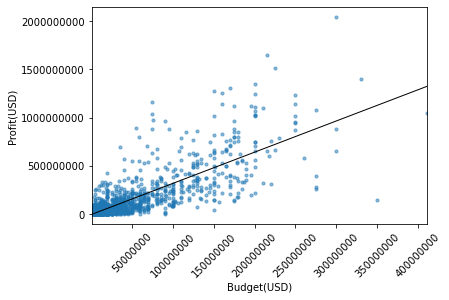

In [10]:
print('The correlation coefficient between gross profit and budget is:',
       round(np.corrcoef(movie_stats['worldwide_gross'], 
       movie_stats['production_budget'])[0][1],2))

sns.regplot(data=movie_stats, 
            x=movie_stats['production_budget'], 
            y=movie_stats['worldwide_gross'],
            ci= None,
            scatter_kws= {'s': 10, 'alpha': .5},
            line_kws={'lw': 1, 'color': 'black'})
plt.xlabel('Budget(USD)')
plt.ylabel('Profit(USD)')
plt.ticklabel_format(style ='plain')
plt.xticks(rotation=45);

The correlation between the 2 values is above .7, this means there is a strong positive correlation between gross profit and production.<!-- https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx
 --> The scatterplot illustrates this point as we see the best fit line as an increasing slope. This is useful information as it shows that the more money that is spent on the film the greater the profit. 
 
Although, this was helpful, it will be more useful to figure out the relationship between the budget and profit multiple. This value will show us, from a business perspective, whether one should invest a lot into a movie in hopes of exponentially multiplying their investment.

The correlation coefficient between gross profit and budget is: -0.05


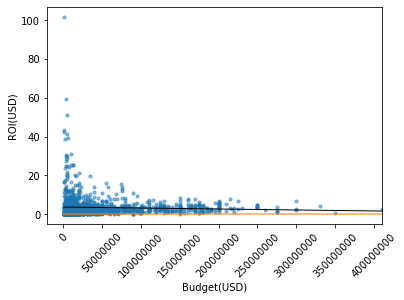

In [11]:
print('The correlation coefficient between gross profit and budget is:',
       round(np.corrcoef(movie_stats['ROI'], 
       movie_stats['production_budget'])[0][1],2))

sns.regplot(data=movie_stats, 
            x=movie_stats['production_budget'], 
            y=movie_stats['ROI'],
            ci= None,
            scatter_kws= {'s': 10, 'alpha': .5},
            line_kws={'lw': 1, 'color': 'black'})
plt.plot([0, 410000000], [0, 0], linewidth=1.5, alpha=.7)
plt.xlabel('Budget(USD)')
plt.ylabel('ROI(USD)')
plt.ticklabel_format(style ='plain')
plt.xticks(rotation=45);

Since the correlation coefficient is below .1 there is negligible correlation between these factors. This shows that from an investors perspective, if interested in multiplying your investment, the size of your budget will not play a major role. 

We also see some of the movies, with smaller budgets multiplied their investment substantially more times than the movies with the higher budgets. On the other hand we see that the lower budget movies had more times where the movie ended up with a loss on their investment.

When we look at the higher budget movies we find that there are virtually no movies that multiplied their investment by more than 10. However, there are also much fewer movies that had a loss on their investment.

What comes out, is that lower budget movies are higher risk and higher reward. As there is a greater chance of making a tremendous profit, but also a greater chance of losing money. While, making a movie with a higher budget is a much safer investment. In that the profit will probably be a small multiple of the amount that one invests in the budget.

### Monetary Analysis by genre

Now lets break up all the films into genres to see how profit differs between genres. 

We will begin by checking out all the values in the `genre` column.

In [12]:
movie_stats.genres.value_counts()

Adventure,Animation,Comedy    68
Comedy                        51
Action,Adventure,Sci-Fi       49
Drama                         46
Comedy,Drama                  45
                              ..
Action,Fantasy,Western         1
Action,Family,Fantasy          1
Adventure,Drama,History        1
Romance,Sci-Fi,Thriller        1
Comedy,Drama,Sport             1
Name: genres, Length: 220, dtype: int64

Clearly it will not be helpful to do analysis on each of the 220 individual genres. Additionally, there are some categories with only one movie with that specific genre. As a result, we cannot learn anything from it, as it is much too small of a sample size. 

Due to this issue, we will run a sql query which breaks the genres up into five main genre dataframes: `Action`, `Comedy`, `Drama`, `Horror`, and `Romance`. We will then use those to create new dataframes which contain just the gross profit for each genre.

In [13]:
a = """
Select movie, genres, averagerating, production_budget, domestic_gross, worldwide_gross,
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from movie_stats
Where genres like '%Drama%'
"""
b = """
Select movie, genres, averagerating, production_budget, domestic_gross, worldwide_gross,
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from movie_stats
Where genres like '%Horror%'
"""
c = """
Select movie, genres, averagerating, production_budget, domestic_gross, worldwide_gross,
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from movie_stats
Where genres like '%Comedy%'
"""
d = """
Select movie, genres, averagerating, production_budget, domestic_gross, worldwide_gross,
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from movie_stats
Where genres like '%Action%'
"""
e = """
Select movie, genres, averagerating, production_budget, domestic_gross, worldwide_gross,
round(worldwide_gross*1.0/production_budget*1.0,2) as ROI
from movie_stats
Where genres like '%Romance%'
"""
df_drama = pysqldf(a)
df_horror = pysqldf(b)
df_comedy = pysqldf(c)
df_action = pysqldf(d)
df_romance = pysqldf(e)

drama_gross = df_drama.worldwide_gross
horror_gross = df_horror.worldwide_gross
comedy_gross = df_comedy.worldwide_gross
action_gross = df_action.worldwide_gross
romance_gross = df_romance.worldwide_gross

We will now run a check to make sure these loaded properly.

In [14]:
romance_gross.head()

0    307166834
1     16566240
2    570998101
3     80504421
4    215448997
Name: worldwide_gross, dtype: int64

Now we will create a histogram of gross profit for each genre. To accomplish this more efficiently we will create three different lists. The first will contain a text version of each genre, this will be used to label the x-axis. The second will contain each of the five new dataframes containing the gross profit. The third will contain five different colors, which will be used to differentiate between the histograms. Finally, we can create a for loop to plot the five different histograms. Additionally, each histogram will contain a vertical line at the mean of each dataset.

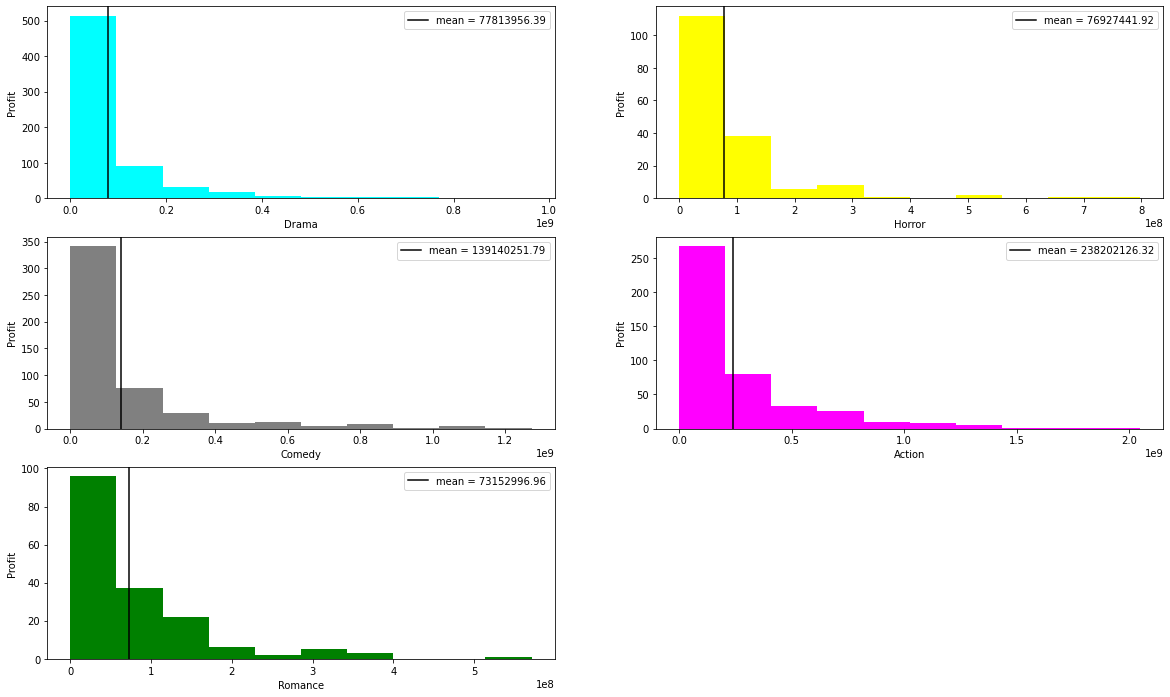

In [15]:
txt_genres=['Drama', 'Horror', 'Comedy', 'Action', 'Romance']
genre_gross = [drama_gross, horror_gross, comedy_gross, action_gross, romance_gross]
colors = ['cyan', 'yellow', 'gray', 'magenta', 'green']

plt.figure(figsize=(20,12))
i=0
for g,c,u in zip(genre_gross, colors, txt_genres):
    i = i+1
    mean = g.mean()
    plt.subplot(3,2,i)
    plt.hist(g, color=c,histtype='bar')
    plt.axvline(mean, color='black', label = 'mean = {}'.format(round(mean,2)))
    plt.xlabel(u)
    plt.ylabel('Profit')
    plt.legend()

Interestingly, all the histograms roughly have the same shape, this shape seems to indicate that profit falls into the pareto distribution.<!-- https://www.youtube.com/watch?v=EAynHZE-lK4 --> Meaning that the minority of movies account for the vast majority of the profit. Additionally, it appears that the genres of action and comedy are the most profitable, while drama, horror, and romance are less profitable.

However, these results may be a function of how much on average each genre is spending on their movies. To investigate this, let's find the average gross vs profit for each genre.

In [16]:
drama_multiple = df_drama.ROI
horror_multiple = df_horror.ROI
comedy_multiple = df_comedy.ROI
action_multiple = df_action.ROI
romance_multiple = df_romance.ROI

multiples = [drama_multiple, horror_multiple, comedy_multiple, action_multiple, romance_multiple]

for g, m in zip(txt_genres, multiples):
    print('The profit multiple for {} is: {}'.format(g.lower(), round(m.mean(),2)))

The profit multiple for drama is: 3.2
The profit multiple for horror is: 7.01
The profit multiple for comedy is: 3.14
The profit multiple for action is: 2.63
The profit multiple for romance is: 3.29


As we predicted the budget for action movies is much greater on average then for other genres. As such the average profit multiple for action movies is the lowest of all the genres. Another significant finding from our data is that although horror movies average gross was standard compared to the other genres, their average budget was far lower then the other genres. As such their profit multiple is atleast double all the other values. This demonstrates that when looking for the best investment, it pays to create a lower budget horror movie.

### Different Way to break up genres
We will now break the data up into genres, and do analysis based on that.

In [52]:
stats_copy = movie_stats

We'll start by splitting all the genres into a list of all the genres for that movie

In [37]:
stats_copy['new_genre'] = stats_copy['genres'].str.split(',')
stats_copy.head()

,movie,genres,runtime_minutes,averagerating,production_budget,domestic_gross,worldwide_gross,ROI,new_genre
0,The Devil Inside,Horror,83.0,4.2,1000000,53262945,101759490,101.76,[Horror]
1,Paranormal Activity 2,Horror,91.0,5.7,3000000,84752907,177512032,59.17,[Horror]
2,Get Out,"Horror,Mystery,Thriller",104.0,7.7,5000000,176040665,255367951,51.07,"[Horror, Mystery, Thriller]"
3,Moonlight,Drama,111.0,7.4,1500000,27854931,65245512,43.50,[Drama]
4,Chernobyl Diaries,"Horror,Mystery,Thriller",86.0,5.0,1000000,18119640,42411721,42.41,"[Horror, Mystery, Thriller]"


Then we will use explode to have one listing of each movie per each genre

In [19]:
stats_copy_explode = stats_copy.explode('new_genre')
stats_copy_explode.head()

,movie,genres,runtime_minutes,averagerating,production_budget,domestic_gross,worldwide_gross,ROI,new_genre
0,The Devil Inside,Horror,83.0,4.2,1000000,53262945,101759490,101.76,Horror
1,Paranormal Activity 2,Horror,91.0,5.7,3000000,84752907,177512032,59.17,Horror
2,Get Out,"Horror,Mystery,Thriller",104.0,7.7,5000000,176040665,255367951,51.07,Horror
2,Get Out,"Horror,Mystery,Thriller",104.0,7.7,5000000,176040665,255367951,51.07,Mystery
2,Get Out,"Horror,Mystery,Thriller",104.0,7.7,5000000,176040665,255367951,51.07,Thriller


We will then group by each genre, and return the count of movies per genre. Since it isn't helpful to use genres with a small sample size, we will only select the genres with at least 150 movies.

In [45]:
count_stats = stats_copy_explode.groupby('new_genre').count().sort_values(by = 'movie', ascending= False)
count_150 = count_stats.loc[count_stats.movie > 150, ['movie']]
count_150

,movie
new_genre,
Drama,676
Comedy,491
Action,432
Adventure,345
Thriller,244
Crime,228
Romance,172
Horror,169


We will then create another df which does the same thing yet shows all the mean statistics.

In [21]:
explode_mean_stats = stats_copy_explode.groupby('new_genre').mean()
explode_mean_stats

,runtime_minutes,averagerating,production_budget,domestic_gross,worldwide_gross,ROI
new_genre,,,,,,
Action,112.321759,6.267824,7.969074e+07,8.627918e+07,2.382021e+08,2.630880
Adventure,111.026087,6.440000,1.060968e+08,1.228029e+08,3.492623e+08,3.113507
Animation,94.320388,6.499029,9.535922e+07,1.326257e+08,3.671644e+08,3.623398
Biography,119.732824,7.018321,2.673053e+07,3.913965e+07,8.148098e+07,3.252748
Comedy,103.016360,6.215275,4.191772e+07,6.094114e+07,1.391403e+08,3.135866
Crime,109.447368,6.315789,3.206952e+07,3.583266e+07,7.650627e+07,2.163377
Documentary,83.421053,6.470000,1.369500e+07,2.216907e+07,4.526666e+07,4.066500
Drama,113.093472,6.581805,2.825050e+07,3.529121e+07,7.781396e+07,3.196494
Family,105.847826,6.164130,6.852609e+07,8.021574e+07,1.995408e+08,2.639565


We will now join our 2 dfs together to create a new df with all the mean statistics for genres with over 150 movies.

In [46]:
main_genres = count_150.merge(explode_mean_stats, how='inner', on = 'new_genre')
main_genres

,movie,runtime_minutes,averagerating,production_budget,domestic_gross,worldwide_gross,ROI
new_genre,,,,,,,
Drama,676,113.093472,6.581805,2.825050e+07,3.529121e+07,7.781396e+07,3.196494
Comedy,491,103.016360,6.215275,4.191772e+07,6.094114e+07,1.391403e+08,3.135866
Action,432,112.321759,6.267824,7.969074e+07,8.627918e+07,2.382021e+08,2.630880
Adventure,345,111.026087,6.440000,1.060968e+08,1.228029e+08,3.492623e+08,3.113507
Thriller,244,106.077869,6.087295,3.396819e+07,4.590177e+07,1.169883e+08,4.839016
Crime,228,109.447368,6.315789,3.206952e+07,3.583266e+07,7.650627e+07,2.163377
Romance,172,107.598837,6.325000,2.394331e+07,3.533904e+07,7.315300e+07,3.286453
Horror,169,97.893491,5.550296,1.977130e+07,3.391291e+07,7.692744e+07,7.010651


Then we will sort the gross values in order to prepare them to be graphed

In [47]:
top_prof = main_genres.worldwide_gross.sort_values(ascending= False)
top_prof

new_genre
Adventure    3.492623e+08
Action       2.382021e+08
Comedy       1.391403e+08
Thriller     1.169883e+08
Drama        7.781396e+07
Horror       7.692744e+07
Crime        7.650627e+07
Romance      7.315300e+07
Name: worldwide_gross, dtype: float64

Finally we will create a bar graph of the values

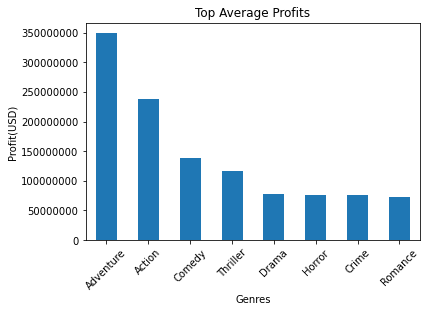

In [48]:
# fig, ax = plt.subplots(figsize=(16, 5))

# # Plot data
# ax.bar(top_10_prof.index, top_10_prof.values)

# # Customize appearance
# ax.tick_params(axis="x", labelrotation=45)
# ax.set_ylabel("Average Profit")
# ax.set_title("Top 10 Average Profits");

top_prof.plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.ylabel('Profit(USD)')
plt.title("Top Average Profits");

Now, we will do the same thing for ROI

In [51]:
top_roi = round(main_genres.ROI.sort_values(ascending= False),2)
top_roi

new_genre
Horror       7.01
Thriller     4.84
Romance      3.29
Drama        3.20
Comedy       3.14
Adventure    3.11
Action       2.63
Crime        2.16
Name: ROI, dtype: float64

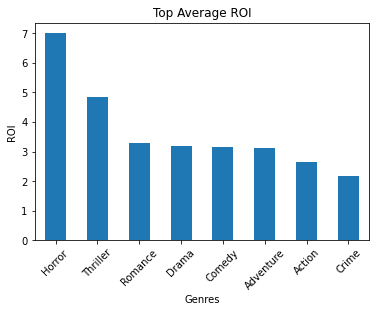

In [50]:
top_roi.plot(kind='bar')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.ylabel('ROI')
plt.title("Top Average ROI");

We will now move on from the monetary analysis, and look at other factors that determine a movies success

### Non-monetary Analysis
We will now move on and look into non monetary statistics. We begin by loading basic info about the imdb_db

In [27]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie            73856 non-null  object 
 1   start_year       73856 non-null  int64  
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.8+ MB


In [28]:
imdb_df.isna().sum()

movie                 0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
dtype: int64

We see that both `runtime_minutes` and `genre` are missing some values. We will have to clean this data before we are able to pull useful information from it.

### Data Cleaning
Lets begin by taking all the movies that are missing their genre and replacing the NaN values with "Absent." This is the most logical way to solve this issue as it won't affect any of the other genres. 
We will then run a check to make sure the values were indeed changed.

In [29]:
imdb_df['genres'] = imdb_df.genres.fillna(value = 'Absent')
imdb_df.isna().sum()

movie                 0
start_year            0
runtime_minutes    7620
genres                0
averagerating         0
dtype: int64

In terms of the values in the `runtime_minutes` column, it wouldn't make sense to create new values for each row randomly selected based on the current distribution of data, as this would create false information for each specific movie. Instead we will drop all of the rows that contain NaN values. Although this seems like a lot of rows we are still left with around 90% of our original data. 
Again we will run a check to make sure it ran properly.

In [30]:
imdb_df = imdb_df.dropna()
imdb_df.isna().sum()

movie              0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
dtype: int64

Additionally, there may be some outlier values that were have a large impact on the mean as well as other aggregate functions. As such lets only include data that is within two standard deviations of the mean. Then we will run a check to make sure the new maximum and minimum seem to be realistic numbers.

In [31]:
#note: ONLY run this cell once. 
# If you run this cell more then once it will keeping cutting the data down.
high_outlier = imdb_df.runtime_minutes.quantile(.9545)
low_outlier = imdb_df.runtime_minutes.quantile(.0455)
imdb_df = imdb_df[~((imdb_df.runtime_minutes < low_outlier)| 
            (imdb_df.runtime_minutes > high_outlier))]
print("The new max is:", max(imdb_df.runtime_minutes))
print("The new min is:", min(imdb_df.runtime_minutes))

The new max is: 137.0
The new min is: 56.0


### Data Analysis
Now, lets plot the distribution of the runtimes to see if there is any useful information

The mean is: 1 hour and 33 minutes 
The median is: 1 hour and 31 minutes 


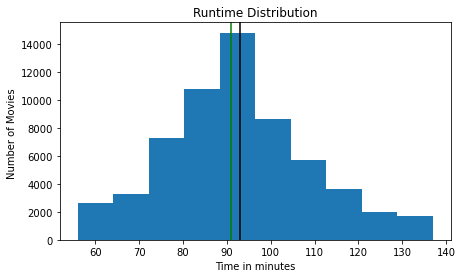

In [32]:
data = imdb_df.runtime_minutes
mean = round(data.mean())
median = round(data.median())

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(data, bins = 10)
ax.axvline(mean, color='black')
ax.axvline(median, color='green')
ax.set_title('Runtime Distribution')
ax.set_xlabel('Time in minutes')
ax.set_ylabel('Number of Movies ')

print('The mean is: {} hour and {} minutes '.format(math.floor(mean/60), int(mean%60)))
print('The median is: {} hour and {} minutes '.format(math.floor(median/60), int(median%60)))

The data seems to be very normal, as the median and mean are only 2 minutes apart. Overall nothing seems to stand out here.

Now lets check if there is any correlation between the length of the movie and its overall rating, and graph the distribution on a scatter plot.

The correlation coefficient between runtime and rating is: -0.02


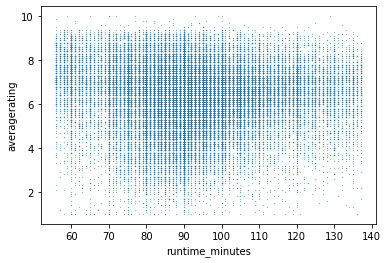

In [33]:
imdb_df.plot.scatter(x = 'runtime_minutes',
                 y = 'averagerating',
                 s = .04)


print('The correlation coefficient between runtime and rating is:',
       round(np.corrcoef(imdb_df['runtime_minutes'], imdb_df['averagerating'])[0][1],2))

With a value of -.02 the relationship is basically non-existent. This is illustrated in the graph, which looks similar to a rain cloud in that there seems to be no recognizable place to put a best fit line

We will move on and break all the movies up by our five main genres. Then we will select only the average rating column from each row.

In [34]:
df_drama = pd.read_sql("""
Select genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
Where genres like '%Drama%'
""",conn)
df_horror = pd.read_sql("""
Select genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
Where genres like '%Horror%'
""",conn)
df_comedy = pd.read_sql("""
Select genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
Where genres like '%Comedy%'
""",conn)
df_action = pd.read_sql("""
Select genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
Where genres like '%Action%'
""",conn)
df_romance = pd.read_sql("""
Select genres, averagerating
from movie_basics
join movie_ratings
    using(movie_id)
Where genres like '%Romance%'
""",conn)

Action_rating = df_action.averagerating
Comedy_rating = df_comedy.averagerating
Drama_rating = df_drama.averagerating
Horror_rating = df_horror.averagerating
Romance_rating = df_romance.averagerating

Now we will plot average rating by genre. Similar to the last time we plotted 5 histograms, we will create a for loop for more efficient code. We will use the `colors` and `txt_genres` list that we created last time. Additionally we will need to create a new list called `genre_rating` which contains the rating dataframes broken up by genre.

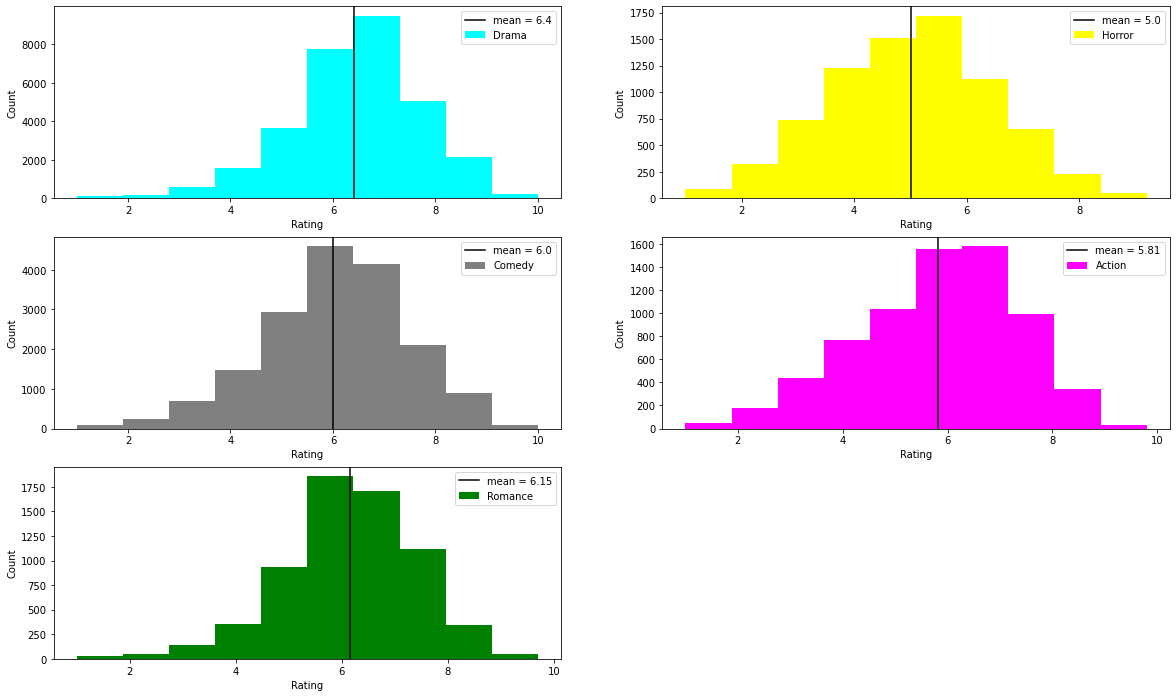

In [35]:
genre_rating = [Drama_rating, Horror_rating, Comedy_rating, Action_rating, Romance_rating]

fig = plt.figure(figsize=(20,12))
i=0
for g,c,u in zip(genre_rating, colors, txt_genres):
    i = i+1
    mean = g.mean()
    plt.subplot(3,2,i)
    plt.hist(g, color=c,histtype='bar', label = u)
    plt.axvline(mean, color='black', label = 'mean = {}'.format(round(mean,2)))
    plt.xlabel('Rating')
    plt.ylabel('Count')
    #plt.title(u)
    plt.legend()

All the histograms have a relatively normal distribution with a slight skew to the left. This shows that most movies are above the mean but there are some values on the low end that pull the mean down and make it lower. 

We also see that in terms of ratings, drama is the highest rated genre, followed by romance. This makes sense as people are looking for feel-good movies and these two genres accomplish that the best. The next ranked genres are comedy and action, these genres are more of a raw form of entertainment, if people want to laugh or see something cool. Finally, we have horror with the lowest average ranking. Although, people choose to go to horror movies, they don't walk out feeling like they had a real experience. The films are made to give people a quick scare without walking away with anything real.

The last thing we should take a look at is the relationship between ratings and gross, to see if there is any correlation between these two. If there is, then it would show us that if one aims to make a movie with higher ratings then a large profit will come along with that.

In [36]:
print('The correlation coefficient between average gross and rating is:',
       round(np.corrcoef(movie_stats['worldwide_gross'], movie_stats['averagerating'])[0][1],2))

The correlation coefficient between average gross and rating is: 0.3


We see that there is a weak relationship, meaning that when making a movie one would have to decide which factor matters more to them. 

## 5. Summary and Recommendations

Overall, we found some very significant results from our monetary analysis of the movie dataframes. 

1. We found that for the most part, the more money one puts into a movie the greater their profit will be. However, this isn't exponential, meaning that the profit multiple on your budget will roughly be the same whether you make a more or less expensive movie. Therefore, if stuck with a lower budget the average percent gain on investment will roughly be the same as if one invested more money into the budget.
2. We found that in a sense the lower budget movies are a riskier investment, as there is more opportunity to have a greater percent gain. At the same time there is greater opportunity for loss. While the higher budget movies had a more stable average percent gain. If one is looking for a riskier investment with high upside they should make a lower budget movie. While if they want a more guaranteed gain on investment it pays to create a higher budget movie. 
3. We found that the distribution of gross profit is subject to the Pareto principle. Meaning that a vast minority of movies are making most of the industries profit. 
4. If one is looking to make the largest gross amount of money the best investment on average is to create a high budget action movie. However, if one is looking for the best investment on average, or if stuck with a lower budget, the best option is to create a horror movie as this genre had over double the percent gain on ones investment.

We then moved on, and looked at non-monetary metrics for success, and found some interesting results.

1. We found that there is basically no correlation between ratings and runtime. Therefore, when making a film, one shouldn't focus on the length of the movie but rather the quality.
2. We found that on average drama and romance are the highest rated genres, followed by comedy and action, with horror in last. As such, if one wants to create a highly rated film, they should make a feel-good drama/ romantic movie. 
3. Lastly, we found that there is very little correlation between gross profit and ratings. This is a meaningful finding, as it teaches us that when focused on making a movie, one has to choose what their metric for success is before making the movie. If they want to make a large profit they will have to focus on very different things then if they were trying to make a movie with high ratings.